<a href="https://colab.research.google.com/github/xahram/Sci-Bert/blob/main/Sci_Bert_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# First step is to load the NIPS data that is uploaded in the Google Drive

In [1]:
# Mount the google drive folder into the directory to access files

from google.colab import drive
drive.mount('/gdrive')


Mounted at /gdrive


In [2]:
# Load all necessary libraries

import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
import time 

nltk.download("punkt")
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [3]:
# Load the NIPS dataset from the drive

nips_papers_df = pd.read_csv('/gdrive/My Drive/Master_dataset/papers.csv')  
nips_papers_df.head()

nips_papers = nips_papers_df.infer_objects()

nips_papers.dtypes

nips_papers["year"] = pd.to_datetime(nips_papers["year"], format="%Y")
# nips_papers['year'] = nips_papers['year'].dt.year
nips_papers.sort_values(by='year')

print(nips_papers.dtypes)

max(nips_papers["year"])
min(nips_papers["year"])

nips_papers = nips_papers.sort_values(by = "year")


id                     int64
year          datetime64[ns]
title                 object
event_type            object
pdf_name              object
abstract              object
paper_text            object
dtype: object


In [4]:
from os import close
# Slice Data Frame by 3 year interval


# print(len(nips_papers))

# Partition/Group Papers into df by the interval/freq of 3 years, closed = left to start combinbing from the 1987
nips_papers_3y_grouped = nips_papers.groupby(pd.Grouper(key='year', freq='3Y', sort=True, closed="left"))



# Save partitions in the Dictionary format with 10 intervals
nips_papers_partitions = {}
initial_partition_id = 0
for i, g  in nips_papers_3y_grouped:
    nips_papers_partitions[initial_partition_id] = g
    initial_partition_id = initial_partition_id + 1


print(nips_papers_partitions)
# nips_papers_three_year_partition[0].tail()


#for i, g in nips_papers.groupby(pd.Grouper(key=nips_papers["year"], freq='A')):
#     print(g)







{0:        id       year                                              title  \
0       1 1987-01-01  Self-Organization of Associative Database and ...   
328    13 1987-01-01   Temporal Patterns of Activity in Neural Networks   
6853   72 1987-01-01  Ensemble' Boltzmann Units have Collective Comp...   
6743   71 1987-01-01  Centric Models of the Orientation Map in Prima...   
6632   70 1987-01-01  On the Power of Neural Networks for Solving Ha...   
...   ...        ...                                                ...   
1650  250 1989-01-01                               Optimal Brain Damage   
1661  251 1989-01-01  A Self-organizing Associative Memory System fo...   
1672  252 1989-01-01  Can Simple Cells Learn Curves? A Hebbian Model...   
1683  253 1989-01-01  Subgrouping Reduces Complexity and Speeds Up L...   
1638  249 1989-01-01  Neural Network Analysis of Distributed Represe...   

     event_type                                           pdf_name  \
0           NaN  1-self-o

In [5]:
# IMPORT word2phrase to create bigrams and unigrams
!git clone https://github.com/travisbrady/word2phrase.git

Cloning into 'word2phrase'...
remote: Enumerating objects: 93, done.
remote: Total 93 (delta 0), reused 0 (delta 0), pack-reused 93
Unpacking objects: 100% (93/93), done.


# ALL TIME WINDOWS SCI-BERT

In [6]:
# Convert List of Time Slice DF paper_text content to lists

start = time.time()

# Loop through every DF and convert paper_text to list and concatenate all the papers of one time slice 
## this will be a list like  ["All paper content string of first slice", "all paper content string of 2nd slice", ...] 

papers_contents_list = [" ".join(time_slice_df["paper_text"].tolist()) for time_slice_df in nips_papers_partitions.values()]

#### MEASURE THE EXECUTION TIME FOR RUNNING THE CONCATENATION CODE

end = time.time()
print(end - start)

# papers_contents_list
# len(papers_contents_list[0])

0.10151219367980957


In [7]:
#  Join Paper titles for bigram and unigram extraction


papers_titles_list = [" ".join(time_slice_df["title"].tolist()) for time_slice_df in nips_papers_partitions.values()]



## Step 1 -  Pre Processing 

# Remove Stopwords 

In [8]:
import re


# function to rmeove digits and numbers from papers 
def regex_remove_digits(papers_contents_list):      
    # Remove any digits for the corpus
    all_time_window_papers_content_list = [re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", time_slice_paper) 
                                                    for time_slice_paper in papers_contents_list] 
    # Remove words with length less than 3 

    # https://stackoverflow.com/questions/24332025/remove-words-of-length-less-than-4-from-string
    all_time_window_papers_content_list = [re.sub(r'\b\w{1,2}\b', '', time_slice_paper) 
                                          for time_slice_paper in all_time_window_papers_content_list]

    return all_time_window_papers_content_list






In [9]:

# Custom Stopwords List for Scientific Literature 
from sklearn.feature_extraction import text

path_to_stop_words = '/gdrive/My Drive/Master_dataset/stopwords_10000_most_frequent_filtered.txt'

with open(path_to_stop_words, "r") as file1:
    FileasList = file1.readlines()


stopwords = [s.strip('\n') for s in FileasList]
print(len(stopwords))


scientific_literature_stopwords = text.ENGLISH_STOP_WORDS.union(stopwords)

print(scientific_literature_stopwords[:-100])
len(scientific_literature_stopwords)



9991


9980

In [10]:
# Get all paper content and titles for bigram and unigram generation
all_time_window_papers_content_list = regex_remove_digits(papers_contents_list)
all_time_window_papers_title_list = regex_remove_digits(papers_titles_list)


## Get Bag Of Candidate Keywords For All Time Windows

In [11]:

all_time_window_papers_titles = " ".join(all_time_window_papers_title_list)
all_time_window_papers_titles = all_time_window_papers_titles.replace(',', '').replace(';', '').replace(":", "")

In [12]:
import nltk
from nltk import word_tokenize
from nltk.util import ngrams
from collections import Counter
from nltk.corpus import stopwords

#About 900 stopwords
stop_words = list(stopwords.words('english')) #About 150 stopwords
stop_words.extend(scientific_literature_stopwords)



token = nltk.word_tokenize(all_time_window_papers_titles)
output = [lemmatizer.lemmatize(w) for w in token if not w in stop_words]

unigrams = ngrams(output,1)
bigrams = ngrams(output,2)



# candidate_keywords = [ for n in ngrams]
n_grams = Counter(bigrams).most_common()
unigrams = Counter(unigrams).most_common()


# unigrams = [ (n[0][0], n[1]) for n in unigrams]
# unigrams

In [13]:
n_grams.extend(unigrams)
# ngrams.extend([])

len(n_grams)

39476

In [14]:


# Sort the bag of words
n_grams = sorted(n_grams, key=lambda item: item[1], reverse=True)



In [15]:
candidate_keywords = [( " ".join(n[0]).lower() , n[1] ) for n in n_grams]
candidate_keywords = candidate_keywords[:1000]



###################################################

In [16]:
candidate_keywords

[('learning', 1447),
 ('neural', 565),
 ('networks', 548),
 ('models', 407),
 ('model', 331),
 ('bayesian', 287),
 ('using', 260),
 ('neural networks', 247),
 ('network', 240),
 ('inference', 221),
 ('data', 221),
 ('analysis', 215),
 ('gaussian', 202),
 ('classification', 194),
 ('optimization', 192),
 ('sparse', 186),
 ('stochastic', 181),
 ('deep', 170),
 ('estimation', 168),
 ('recognition', 163),
 ('efficient', 163),
 ('clustering', 162),
 ('algorithms', 160),
 ('kernel', 155),
 ('reinforcement', 151),
 ('reinforcement learning', 148),
 ('algorithm', 144),
 ('online', 144),
 ('adaptive', 143),
 ('linear', 138),
 ('regression', 138),
 ('optimal', 136),
 ('fast', 136),
 ('neural network', 135),
 ('markov', 133),
 ('information', 132),
 ('visual', 131),
 ('image', 128),
 ('approach', 125),
 ('probabilistic', 121),
 ('processes', 120),
 ('feature', 114),
 ('gradient', 113),
 ('variational', 113),
 ('prediction', 111),
 ('modeling', 109),
 ('process', 109),
 ('methods', 109),
 ('robust

## Monitoring Keywords

In [17]:
vec2dynamics_keywords = ['neural network', 'reinforcement learning', 'active learning', 'monte carlo', 'deep learning',
                          'machine learning', 'supervised learning', 'time series', 'artificial neural',
                         'gaussian process', 'active learning', 'gradient descent', 'hidden markov',
                         'nearest neighbor', 'dynamical system', 'dimensionality reduction',
                         'unsupervised learning', 'graphical model', 'dynamic programming', 'component analysis'
                         ,'supervised','learning', 'model', 'reinforcement', 'markov', 'gradient', 'markov', 'neighbor','gaussian']

In [18]:
# keywords_np = np.array(candidate_keywords)

candidate_keywords_ = np.array([keyword[0] for keyword in candidate_keywords])

candidate_keywords_

array(['learning', 'neural', 'networks', 'models', 'model', 'bayesian',
       'using', 'neural networks', 'network', 'inference', 'data',
       'analysis', 'gaussian', 'classification', 'optimization', 'sparse',
       'stochastic', 'deep', 'estimation', 'recognition', 'efficient',
       'clustering', 'algorithms', 'kernel', 'reinforcement',
       'reinforcement learning', 'algorithm', 'online', 'adaptive',
       'linear', 'regression', 'optimal', 'fast', 'neural network',
       'markov', 'information', 'visual', 'image', 'approach',
       'probabilistic', 'processes', 'feature', 'gradient', 'variational',
       'prediction', 'modeling', 'process', 'methods', 'robust',
       'dynamic', 'recurrent', 'hierarchical', 'detection', 'training',
       'random', 'time', 'structured', 'control', 'functions',
       'selection', 'application', 'bounds', 'sampling',
       'representations', 'local', 'latent', 'structure', 'unsupervised',
       'model', 'machine', 'search', 'large', 'v

In [19]:
list(set(vec2dynamics_keywords) - set(candidate_keywords_))

['dynamical system']

In [20]:
monitering_keywords = list(set(vec2dynamics_keywords).intersection(set(candidate_keywords_)))
monitering_keywords = monitering_keywords[:20]

In [21]:

# candidate_keywords = candidate_keywords_

len(monitering_keywords)

20

## Step 2.1 - Get Vocabulary list

In [22]:
papers_contents_list = [" ".join(time_slice_df["paper_text"].tolist()).lower() for time_slice_df in nips_papers_partitions.values()]


In [23]:
import re


# function to rmeove digits and numbers from papers 
def v_preprocess(papers_contents_list):      
    # Remove any digits for the corpus
    # all_time_window_papers_content_list = list( (re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", time_slice_paper) 
    #                                                 for time_slice_paper in papers_contents_list) )
    # Remove words with length less than 3 

    # https://stackoverflow.com/questions/24332025/remove-words-of-length-less-than-4-from-string
    # all_time_window_papers_content_list = list( (re.sub(r'\b\w{1,2}\b', ' ', time_slice_paper) 
    #                                       for time_slice_paper in all_time_window_papers_content_list) )


    # remove words with number in it 
    # https://stackoverflow.com/questions/18082130/python-regex-to-remove-all-words-which-contains-number

    # all_time_window_papers_content_list = list( (re.sub(r'\w*\d\w*', ' ', time_slice_paper) 
    #                                       for time_slice_paper in all_time_window_papers_content_list) )
    


    # REMOVE SLASHES
    # https://stackoverflow.com/questions/33470048/removing-words-with-special-characters-and
    # all_time_window_papers_content_list = list( (re.sub(r'\s*(?:[\w_]*[/\\\(\)\]\[\-\~\,\.\-\+](?:[\w_]*[/\\\(\)\]\[\\-\~\,\.\-\+])*[\w_]*)', ' ', time_slice_paper) 
    #                                       for time_slice_paper in all_time_window_papers_content_list) )
    

    



    #####################################


    all_time_window_papers_content_list = list( (re.sub(r'\w*\d\w*', ' ', time_slice_paper) 
                                          for time_slice_paper in papers_contents_list) )
    

    all_time_window_papers_content_list = list( (re.sub(r"[~.,%/:;?_&+*=!-]", ' ', time_slice_paper) 
                                          for time_slice_paper in all_time_window_papers_content_list) )
    
    
    all_time_window_papers_content_list = list( (re.sub(r'[^a-z]', ' ', time_slice_paper) 
                                          for time_slice_paper in all_time_window_papers_content_list) )
    
    

    all_time_window_papers_content_list = list( (re.sub(r'\s{2,}', ' ', time_slice_paper) 
                                          for time_slice_paper in all_time_window_papers_content_list) )
    
    

    return all_time_window_papers_content_list






In [24]:
len(papers_contents_list[9])

46835872

In [25]:
papers_contents_list = v_preprocess(papers_contents_list)

In [26]:
len(papers_contents_list[0])

4981941

In [27]:
# For optimization purpose
import nltk
from nltk import sent_tokenize, word_tokenize
from nltk.tokenize import ToktokTokenizer
toktok = ToktokTokenizer()

def vocabulary(C):
    v = list(lemmatizer.lemmatize(w) for w in nltk.word_tokenize(C) if w not in stop_words and len(w) > 2 )
    # v = C
    uni = ngrams(v,1)
    bi = ngrams(v,2)


    b = Counter(bi).most_common()
    u = Counter(uni).most_common()

    b.extend(u)
    # ( " ".join(n[0]) , n[1] ) for n in n_grams
    v = [" ".join(item[0])  for item in b if item[1] > 5]


    # v = list(set( (lemmatizer.lemmatize(w) for w in nltk.word_tokenize(C) if w not in stop_words) ))
    # v = list( set( (lemmatizer.lemmatize(w) for sent in sent_tokenize(C)  for w in toktok.tokenize(sent) if w not in stop_words) ) )
    return v

In [ ]:
# import time

# start = time.time()

# v10 = vocabulary(papers_contents_list[9])

# end = time.time()
# print(end - start)

In [ ]:
v1 = vocabulary(papers_contents_list[0])
# v10 = vocabulary( papers_contents_list[9]) 


In [ ]:
# v9[:100]

In [ ]:
v2 = vocabulary(papers_contents_list[1]) 
v3 = vocabulary(papers_contents_list[2]) 
v4 = vocabulary(papers_contents_list[3]) 
v5 = vocabulary(papers_contents_list[4]) 
v6 = vocabulary(papers_contents_list[5]) 


In [ ]:
v_map = {

    "v1":v1,
    "v2":v2,
    "v3":v3,
    "v4":v4,
    "v5":v5,
    "v6":v6
}

import pickle
with open('/gdrive/My Drive/Master_dataset/vocabulary_6test.pickle', 'wb+') as f:
     pickle.dump(v_map, f)

In [ ]:
v7 = vocabulary(papers_contents_list[6]) 
v8 = vocabulary(papers_contents_list[7]) 


v_map2 = {

    "v7":v7,
    "v8":v8,
}


import pickle
with open('/gdrive/My Drive/Master_dataset/vocabulary_6test.pickle', 'ab+') as f:
     pickle.dump(v_map2, f)

In [ ]:

v9 = vocabulary(papers_contents_list[8]) 
v10 = vocabulary( papers_contents_list[9]) 


v_map3 = {
    
    "v9":v9,
    "v10":v10
}



import pickle
with open('/gdrive/My Drive/Master_dataset/vocabulary_6test.pickle', 'ab+') as f:
     pickle.dump(v_map3, f)

In [28]:
import pickle
with open('/gdrive/My Drive/Master_dataset/vocabulary_6test.pickle', 'rb+') as f:
     v_map_1 = pickle.load(f)
     v_map_2 = pickle.load(f)
     v_map_3 = pickle.load(f)



In [29]:
v_map = {
    **v_map_1,
    **v_map_2,
    **v_map_3
}


v1 = v_map["v1"]
v2 = v_map["v2"]
v3 = v_map["v3"]
v4 = v_map["v4"]
v5 = v_map["v5"]
v6 = v_map["v6"]
v7 = v_map["v7"]
v8 = v_map["v8"]
v9 = v_map["v9"]
v10 = v_map["v10"]




In [30]:
print(f"Length of \n V1={len(v1)} \n V2={len(v2)} \n V3={len(v3)} \n V4={len(v4)} \n V5={len(v5)} \n V6={len(v6)} \n V7={len(v7)} \n V8={len(v8)} \n V9={len(v9)} V10={len(v10)}")

Length of 
 V1=5884 
 V2=8044 
 V3=9336 
 V4=9420 
 V5=10521 
 V6=14482 
 V7=16802 
 V8=25136 
 V9=34881 V10=49332


### Step 3 - BERT EMBEDDING GENERATE

In [31]:
title_ngram_candidate_keywords_time_slices_sorted_ = [ngram[0] for ngram in candidate_keywords]
# t = "\n".join(title_ngram_candidate_keywords_time_slices_sorted_)
t = "\n".join(monitering_keywords)

t

'active learning\ndynamic programming\nartificial neural\nmarkov\ndeep learning\nnearest neighbor\nmachine learning\nreinforcement\ngraphical model\ntime series\ndimensionality reduction\ncomponent analysis\nsupervised\nsupervised learning\nneural network\nmonte carlo\nlearning\nneighbor\nunsupervised learning\nreinforcement learning'

In [32]:
!pip install pytorch-pretrained-bert
!pip install Unidecode
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 123 kB 8.3 MB/s 
     |████████████████████████████████| 132 kB 54.4 MB/s 
     |████████████████████████████████| 9.1 MB 65.9 MB/s 
     |████████████████████████████████| 79 kB 9.4 MB/s 
     |████████████████████████████████| 140 kB 72.8 MB/s 
     |████████████████████████████████| 127 kB 68.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 8.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 7.6 MB/s 
     |████████████████████████████████| 120 kB 57.4 MB/s 
     |█████████████████████

In [33]:
import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM, BertConfig
from collections import OrderedDict
import unidecode
import numpy as np

from transformers import BertModel, BertConfig, BertTokenizer

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
logging.basicConfig(level=logging.INFO)
import os
import matplotlib.pyplot as plt
# % matplotlib inline

In [34]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
import torch
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

Found GPU at: /device:GPU:0


'Tesla T4'

In [35]:
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

#Use the pre-trained Base BERT model 
# model = BertModel.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased',output_hidden_states = True)

model.cuda()
# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [36]:
from collections import OrderedDict
class Data():

    def __getitem__(self, content=None):
         if content!=None:
             self.doc = " ".join(content)
         return self.doc
     
    def _preprocess(self,targets,corpus):
        self.index=[]
        self.t_index=OrderedDict()
        for target in targets:
            
            for _,item in enumerate(corpus):
                # if target in item:
                  if item.lower().find(target) != -1:
                # if bool(re.search(target, item)):

                  # Check if sentence has multiple occurances of the target term
                      count_target=item.count(target)
                  #   Avoiding the sentences with multiple occurrences of the target term for the time being###
                      if count_target==1:
                        if target not in self.t_index.keys():
                            self.t_index[target]=[_]
                        else:
                            self.t_index[target].append(_)
                        self.index.append(_)
        return self.index,self.t_index

In [ ]:
# datasets.__getitem__(t).split('\n')
# t.split('\n')


In [37]:
'''
LOAD & EXTRACT DATA
'''
import os



p1 = nips_papers_partitions[0]["paper_text"].tolist()
p2 = nips_papers_partitions[1]["paper_text"].tolist()
p3 = nips_papers_partitions[2]["paper_text"].tolist()
p4 = nips_papers_partitions[3]["paper_text"].tolist()
p5 = nips_papers_partitions[4]["paper_text"].tolist()
p6 = nips_papers_partitions[5]["paper_text"].tolist()
p7 = nips_papers_partitions[6]["paper_text"].tolist()
p8 = nips_papers_partitions[7]["paper_text"].tolist()
p9 = nips_papers_partitions[8]["paper_text"].tolist()
p10 = nips_papers_partitions[9]["paper_text"].tolist()





t = t
datasets = Data() 

# doc1 =  ["Sentence1", "Sentence2".....]
doc1=datasets.__getitem__(p1).split('\n')   
doc2=datasets.__getitem__(p2).split('\n')
doc3=datasets.__getitem__(p3).split('\n')
doc4=datasets.__getitem__(p4).split('\n')
doc5=datasets.__getitem__(p5).split('\n')
doc6=datasets.__getitem__(p6).split('\n')
doc7=datasets.__getitem__(p7).split('\n')
doc8=datasets.__getitem__(p8).split('\n')
doc9=datasets.__getitem__(p9).split('\n')
doc10=datasets.__getitem__(p10).split('\n')


t1=(t).split('\n')
target_act=[x for x in t1 if len(x)>1]
t1=[x.lower() for x in t1 if len(x)>1]

index1=datasets._preprocess(t1,doc1)
index2=datasets._preprocess(t1,doc2)
index3=datasets._preprocess(t1,doc3)
index4=datasets._preprocess(t1,doc4)
index5=datasets._preprocess(t1,doc5)
index6=datasets._preprocess(t1,doc6)
index7=datasets._preprocess(t1,doc7)
index8=datasets._preprocess(t1,doc8)
index9=datasets._preprocess(t1,doc9)
index10=datasets._preprocess(t1,doc10)


index_t1=index1[1]
index_t2=index2[1]
index_t3=index3[1]
index_t4=index4[1]
index_t5=index5[1]
index_t6=index6[1]
index_t7=index7[1]
index_t8=index8[1]
index_t9=index9[1]
index_t10=index10[1]

print('The target words are:',t1)
target_words=t1

print('The index_t1 are ', index_t1)
print('The index_t2 are ', index_t2)


#conversions
target_uni=[unidecode.unidecode(m) for m in t1]
target_toks=[]
# print(target_uni)
for k in t1:
  target_toks.append(tokenizer.tokenize(k))
print('converted target toks',target_toks)

The target words are: ['active learning', 'dynamic programming', 'artificial neural', 'markov', 'deep learning', 'nearest neighbor', 'machine learning', 'reinforcement', 'graphical model', 'time series', 'dimensionality reduction', 'component analysis', 'supervised', 'supervised learning', 'neural network', 'monte carlo', 'learning', 'neighbor', 'unsupervised learning', 'reinforcement learning']
The index_t1 are  OrderedDict([('active learning', [43726, 43898, 130427]), ('dynamic programming', [15369, 15459, 15460, 92015, 92016, 92296, 109868, 137730]), ('artificial neural', [15376, 15388, 15895, 18681, 20674, 21139, 23175, 26844, 26914, 33248, 33251, 33258, 33260, 33277, 33329, 33431, 33457, 33462, 33468, 33472, 34021, 34253, 34258, 34948, 34959, 35532, 35704, 39555, 39568, 52209, 52211, 52218, 52257, 52289, 52370, 52391, 52414, 53161, 53374, 59028, 65768, 67647, 69960, 74270, 74284, 75827, 75833, 75863, 75873, 75889, 76351, 76397, 82594, 82599, 83219, 83227, 87086, 88961, 92819, 9370

In [ ]:
len(t1)
print(len(index_t1))
print(len(index_t2))
# target_toks

len(list(index_t1.values())[1])


In [38]:
def _pre_bert(doc,index,t):
  
  # index =  index_t1 -> { target_w1: index, target_w2: index2, target_w1 : index5 } -  index = Sentence index in which target word appears
  s=["Not Found"]  
  
  if t in index.keys():
      s=[doc[ind] for ind in index[t]]

  print('len of sentences',len(s))
  l=len(s)
  marked_text = ["[CLS] " + text + " [SEP]" for text in s]
  tokenized_text = [tokenizer.tokenize(m) for m in marked_text]
  
  tokenized_text=[x[:512] if len(x)>512 else x for x in tokenized_text]

  indexed_tokens = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_text]
  segments_ids = [[1] * len(x) for x in tokenized_text]
  return s,marked_text,tokenized_text,indexed_tokens,segments_ids,l


def _bert_features(tokens_tensor, segments_tensors,tokenized_text):
  # print(len(tokens_tensor[0]))
  with torch.no_grad():
      # _ , __ , encoded_layers= model(tokens_tensor.to(device), segments_tensors.to(device))
      outputs = model(tokens_tensor.to(device), segments_tensors.to(device))
      encoded_layers = outputs[2]
      # encoded_layers , _ = model(tokens_tensor.to(device), segments_tensors.to(device))

  # print ("Number of layers:", len(encoded_layers))
  layer_i = 0

  # print ("Number of batches:", len(encoded_layers[layer_i]))
  batch_i = 0

  # print ("Number of tokens:", len(encoded_layers[layer_i][batch_i]))
  token_i = 0

  # print ("Number of hidden units:", len(encoded_layers[layer_i][batch_i][token_i]))

  # print ("Number of hidden units:", len(encoded_layers[layer_i][batch_i][token_i]))
  # Convert the hidden state embeddings into single token vectors

  # Holds the list of 12 layer embeddings for each token
  # Will have the shape: [# tokens, # layers, # features]
  token_embeddings = [] 



  # For each token in the sentence...
  # tokenized_text=[x for x in tokenized_text if x not in ['_', 'n', '##n','v', '##b']]
  for token_i in range(len(tokenized_text)):

    #print(f"tokenized text {len(tokenized_text)} \n")
    #print(f"encoded layer {len(encoded_layers[layer_i][batch_i][2])} \n")
    
    # For some reason original is not producing the same tokes tokeinzed_text=[[ tokens of sentence 1 ],[ tokens of sentence 2 ]] <= for one tg word
    # Holds 12 layers of hidden states for each token 
    hidden_layers = [] 
    
    # For each of the 12 layers...
    for layer_i  in range(len(encoded_layers)):
      
      # Lookup the vector for `token_i` in `layer_i`
      # print((encoded_layers[layer_i][batch_i][token_i]))
      vec = encoded_layers[layer_i][batch_i][token_i]
      
      hidden_layers.append(vec)
      
    token_embeddings.append(hidden_layers)

  # Sanity check the dimensions:
  # print ("Number of tokens in sequence:", len(token_embeddings))
  # print ("Number of layers per token:", len(token_embeddings[0]))
  return token_embeddings
# s,marked_text,tokenized_text,indexed_tokens,segments_ids
def _get_embeddings(pre,tg):
  m_embed_full=[]
  # print('len(pre[0])',len(pre[0]))
  # print(tg)
  for _,item in enumerate(pre[0]):
    # Convert inputs to PyTorch tensors
    # print(item)
    token_list=pre[2][_]
    
    tokens_tensor = torch.tensor([pre[3][_]])
    segments_tensors = torch.tensor([pre[4][_]])
    # Predict hidden states features for each layer
    token_embeddings=_bert_features(tokens_tensor, segments_tensors,pre[2][_])
    concatenated_last_4_layers = [torch.cat((layer[-1], layer[-2], layer[-3], layer[-4]), 0) for layer in token_embeddings] # [number_of_tokens, 3072]

    summed_last_4_layers = [torch.sum(torch.stack(layer)[-4:], 0) for layer in token_embeddings] # [number_of_tokens, 768]
    
    #consider the tokenized target
  
    indxs=[]
    # print(token_list)
    for tok in tg:
      '''
      remove -1,-2,-3
      '''
      if tok in token_list:
        if tok not in ['_', 'n', '##n','v', '##b']:
          indxs.append(token_list.index(tok))

    # print('indxs',indxs)
    if len(indxs)==1:
      #bert_embed=concatenated_last_4_layers [indxs[0]]
      bert_embed=summed_last_4_layers [indxs[0]]

      m_embed_full.append(bert_embed)
    elif len(indxs)>1:
      b_emb=[]
      for ind in indxs:
        #b_emb.append(concatenated_last_4_layers[ind])
        b_emb.append(summed_last_4_layers[ind])
        
      bert_embed= torch.sum(torch.stack(b_emb), 0)
      m_embed_full.append(bert_embed)
    # indx=token_list.index(tg.lower())
    # indx = [i for (i, elem) in enumerate(pre[2][_]) if t in elem]
    # print('indx',indx)
    # print(pre[1][_],indx)

    # if len(indx)>0:
    # bert_embed=concatenated_last_4_layers[indx[0]]
    
    # cosine_similarity(summed_last_4_layers[10].reshape(1,-1), summed_last_4_layers[19].reshape(1,-1))[0][0]
    
    
  return  m_embed_full, summed_last_4_layers
# For a particular target word,do clustering and find if there is a sense change


In [39]:
# Embedding for all time windows

sents_all=[]

# Holds all bert embeddings 
# [] -> [[embedding1], [embedding2],...]
X=[]

def embeddings_extract(target_words,target_toks,doc1,index_t1):
  t=target_words
  X_C1=[]
  lens1=[]
  print(f"target_words {target_words}")
  for k,t in enumerate(target_words) :
    berts=[]
    sents=[]
    print('The target word is',t)    
    
    #get the sentences from corpus c1 and c2 for the specific target word 't'
    
    # This will generate tokenized sentences, tokens for the specific word. Or sentences containing specific word
    pre1=_pre_bert(doc1,index_t1,t)

    # lens1.append(pre1[-1])
    # lens2.append(pre2[-1])
    # print(pre1)
    
    sents.extend(pre1[0])
    #aggregate all the embeddings
    # s,marked_text,tokenized_text,indexed_tokens,segments_ids

    '''
    Get the embeddings of the targets from corpus 1 and 2
    '''
    _ , b1=_get_embeddings(pre1,target_toks[k])
    print('len of t1',len(b1))
    
    '''
    store the lenghts of no. of sentences extracted for each target word for each corpus
    '''
    lens1.append(len(b1))
    
    berts.extend(b1)
    print('len of each target word extractions is',len(berts))
    X.append(berts)

    # ______________ Placeholder to flatten the tensors into 1-D tensor for the 
    #           respective sentence tensors of specific keyword _______________ (b1)
    b2= torch.sum(torch.stack(b1), 0)

    X_C1.append(b2)# the embeddings for C1
    sents_all.append(sents)
  return X,X_C1,lens1,sents_all



In [40]:
#### BERT FOR Vocabulary

def bert_text_preparation(text, tokenizer):
    marked_text = "[CLS] " + text + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [1]*len(indexed_tokens)

    # Convert inputs to PyTorch tensors
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])

    return tokenized_text, tokens_tensor, segments_tensors









def extract_v_embeddings(v):
    target_word_embeddings = []
    for text in v:

        print(f"Target word is {text}")

        tokenized_text, tokens_tensor, segments_tensors = bert_text_preparation(text, tokenizer)
        list_token_embeddings = _bert_features(tokens_tensor, segments_tensors, tokenized_text)
        summed_last_4_layers = [torch.sum(torch.stack(layer)[-4:], 0) for layer in list_token_embeddings] # [number_of_tokens, 768]
        bert_embed= torch.sum(torch.stack(summed_last_4_layers), 0)
        # # Find the position 'bank' in list of tokens
        # word_index = tokenized_text.index('bank')
        # # Get the embedding for bank
        # word_embedding = list_token_embeddings[word_index]

        # target_word_embeddings.append(word_embedding)
        target_word_embeddings.append(bert_embed)
        
    return  target_word_embeddings



In [ ]:
# import time

# start = time.time()
# v1_emb = extract_v_embeddings(v1)

# end = time.time()
# print(f'Time {end - start} \n')
# len(v1_emb)


In [43]:
v1_emb = extract_v_embeddings(v1)
v2_emb = extract_v_embeddings(v2)
v3_emb = extract_v_embeddings(v3)
v4_emb = extract_v_embeddings(v4)
v5_emb = extract_v_embeddings(v5)



Streaming output truncated to the last 5000 lines.
Target word is constructing
Target word is statistically
Target word is integrate
Target word is permutation
Target word is assumes
Target word is transforms
Target word is eigenvector
Target word is sigmoidal
Target word is finding
Target word is initially
Target word is layout
Target word is analytically
Target word is friedman
Target word is structured
Target word is empirically
Target word is distortion
Target word is mozer
Target word is usa
Target word is encode
Target word is transformation
Target word is realistic
Target word is sci
Target word is situation
Target word is dendrite
Target word is structural
Target word is generates
Target word is encoded
Target word is scenario
Target word is ion
Target word is attentional
Target word is bethe
Target word is score
Target word is lab
Target word is vlsi
Target word is modelling
Target word is plasticity
Target word is science
Target word is enables
Target word is motivated
Target

In [44]:
v_map1 = {

    "v1_emb":v1_emb,
    "v2_emb":v2_emb,
    "v3_emb":v3_emb,
    "v4_emb":v4_emb,
    "v5_emb":v5_emb
}

import pickle
with open('/gdrive/My Drive/Master_dataset/vocabulary_emb5test.pickle', 'wb+') as f:
     pickle.dump(v_map1, f)

In [45]:

v6_emb = extract_v_embeddings(v6)
v7_emb = extract_v_embeddings(v7)
v8_emb = extract_v_embeddings(v8)

v_map2 = {

    "v6_emb":v6_emb,
    "v7_emb":v7_emb,
    "v8_emb":v8_emb
}

import pickle
with open('/gdrive/My Drive/Master_dataset/vocabulary_emb5test.pickle', 'ab+') as f:
     pickle.dump(v_map2, f)

Streaming output truncated to the last 5000 lines.
Target word is luster
Target word is mpot
Target word is rmc
Target word is til
Target word is figural
Target word is mesa
Target word is cardiologist
Target word is vos
Target word is ov
Target word is deo
Target word is kzd
Target word is rcp
Target word is chainboost
Target word is lmip
Target word is glymour
Target word is pfc
Target word is incentive
Target word is substrate
Target word is integrative
Target word is magenta
Target word is stabilize
Target word is parallel
Target word is exhaustively
Target word is laplacians
Target word is ellipse
Target word is positioned
Target word is leveraged
Target word is sacrificing
Target word is runtimes
Target word is unavailable
Target word is negation
Target word is raj
Target word is atlanta
Target word is jasa
Target word is php
Target word is vowel
Target word is elsevier
Target word is vastly
Target word is kulesza
Target word is tps
Target word is anatomically
Target word is sig


In [46]:

v9_emb = extract_v_embeddings(v9)
v10_emb = extract_v_embeddings(v10)


v_map3 = {

    "v9_emb":v9_emb,
    "v10_emb":v10_emb
}

import pickle
with open('/gdrive/My Drive/Master_dataset/vocabulary_emb5test.pickle', 'ab+') as f:
     pickle.dump(v_map3, f)

Streaming output truncated to the last 5000 lines.
Target word is wiskott
Target word is pendleton
Target word is roweth
Target word is une
Target word is que
Target word is auli
Target word is quirk
Target word is cernock
Target word is persists
Target word is lewandowski
Target word is tum
Target word is qks
Target word is decorrelating
Target word is rej
Target word is subhransu
Target word is visitation
Target word is permeability
Target word is sinusoid
Target word is hallway
Target word is daw
Target word is santini
Target word is tc
Target word is lsong
Target word is saarbr
Target word is marginalizes
Target word is relieff
Target word is convolve
Target word is prl
Target word is mania
Target word is snyder
Target word is santos
Target word is alluded
Target word is emanuel
Target word is jethava
Target word is zachary
Target word is pni
Target word is specific
Target word is dvt
Target word is reza
Target word is informatique
Target word is ltb
Target word is northwestern
Tar

In [ ]:
# import time
# start_time = time.time()

# embed_full,embed_C1,len_c1,sents=embeddings_extract(target_words,target_toks,doc1,index_t1)

# lens=[len_c1]
# # lens.append(len_c2)
# print('saved')
# print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
print(target_words)

In [ ]:
print("")

In [47]:
# BERT Embeddings

embed_full,embed_C1,len_c1,sents=embeddings_extract(target_words,target_toks,doc1,index_t1)
embed_full,embed_C2,len_c2,sents=embeddings_extract(target_words,target_toks,doc2,index_t2)
embed_full,embed_C3,len_c3,sents=embeddings_extract(target_words,target_toks,doc3,index_t3)
embed_full,embed_C4,len_c4,sents=embeddings_extract(target_words,target_toks,doc4,index_t4)
embed_full,embed_C5,len_c5,sents=embeddings_extract(target_words,target_toks,doc5,index_t5)


target_words ['gaussian', 'gradient descent', 'artificial neural', 'unsupervised learning', 'nearest neighbor', 'model', 'graphical model', 'time series', 'markov', 'gaussian process', 'deep learning', 'learning', 'supervised', 'active learning', 'dynamic programming', 'monte carlo', 'neighbor', 'dimensionality reduction', 'machine learning', 'neural network']
The target word is gaussian
len of sentences 75
len of t1 23
len of each target word extractions is 23
The target word is gradient descent
len of sentences 106
len of t1 12
len of each target word extractions is 12
The target word is artificial neural
len of sentences 73
len of t1 17
len of each target word extractions is 17
The target word is unsupervised learning
len of sentences 27
len of t1 22
len of each target word extractions is 22
The target word is nearest neighbor
len of sentences 67
len of t1 19
len of each target word extractions is 19
The target word is model
len of sentences 2308
len of t1 32
len of each target word

In [41]:
saved_map3 = {

    "embed_C1":embed_C1,
    "embed_C2":embed_C2,
    "embed_C3":embed_C3,
    "embed_C4":embed_C4,
    "embed_C5":embed_C5
}

import pickle
with open('/gdrive/My Drive/Master_dataset/bert_embeddings_7test.pickle', 'wb+') as f:
     pickle.dump(saved_map3, f)

NameError: ignored

In [49]:
embed_full,embed_C6,len_c6,sents=embeddings_extract(target_words,target_toks,doc6,index_t6)
embed_full,embed_C7,len_c7,sents=embeddings_extract(target_words,target_toks,doc7,index_t7)
embed_full,embed_C8,len_c8,sents=embeddings_extract(target_words,target_toks,doc8,index_t8)





saved_map4 =  {
    "embed_C6":embed_C6,
    "embed_C7":embed_C7,
    "embed_C8":embed_C8
    }

import pickle
with open('/gdrive/My Drive/Master_dataset/bert_embeddings_7test.pickle', 'ab+') as f:
     pickle.dump(saved_map4, f)

target_words ['gaussian', 'gradient descent', 'artificial neural', 'unsupervised learning', 'nearest neighbor', 'model', 'graphical model', 'time series', 'markov', 'gaussian process', 'deep learning', 'learning', 'supervised', 'active learning', 'dynamic programming', 'monte carlo', 'neighbor', 'dimensionality reduction', 'machine learning', 'neural network']
The target word is gaussian
len of sentences 131
len of t1 30
len of each target word extractions is 30
The target word is gradient descent
len of sentences 115
len of t1 26
len of each target word extractions is 26
The target word is artificial neural
len of sentences 28
len of t1 14
len of each target word extractions is 14
The target word is unsupervised learning
len of sentences 80
len of t1 28
len of each target word extractions is 28
The target word is nearest neighbor
len of sentences 152
len of t1 40
len of each target word extractions is 40
The target word is model
len of sentences 9509
len of t1 38
len of each target wo

In [50]:
embed_full,embed_C9,len_c9,sents=embeddings_extract(target_words,target_toks,doc9,index_t9)
embed_full,embed_C10,len_c10,sents=embeddings_extract(target_words,target_toks,doc10,index_t10)



saved_map5 = {
    "embed_C9":embed_C9,
    "embed_C10":embed_C10,
    "sents":sents,
    "embed_full":embed_full
}
    

import pickle
with open('/gdrive/My Drive/Master_dataset/bert_embeddings_7test.pickle', 'ab+') as f:
     pickle.dump(saved_map5, f)

target_words ['gaussian', 'gradient descent', 'artificial neural', 'unsupervised learning', 'nearest neighbor', 'model', 'graphical model', 'time series', 'markov', 'gaussian process', 'deep learning', 'learning', 'supervised', 'active learning', 'dynamic programming', 'monte carlo', 'neighbor', 'dimensionality reduction', 'machine learning', 'neural network']
The target word is gaussian
len of sentences 272
len of t1 37
len of each target word extractions is 37
The target word is gradient descent
len of sentences 553
len of t1 19
len of each target word extractions is 19
The target word is artificial neural
len of sentences 28
len of t1 66
len of each target word extractions is 66
The target word is unsupervised learning
len of sentences 178
len of t1 20
len of each target word extractions is 20
The target word is nearest neighbor
len of sentences 462
len of t1 28
len of each target word extractions is 28
The target word is model
len of sentences 21800
len of t1 22
len of each target 

## Apply K-NN with Cosine Similarity 

In [57]:
print("")

In [42]:
import pickle
import numpy as np
import pandas as pd
import nltk
import torch


In [44]:
with open('/gdrive/My Drive/Master_dataset/vocabulary_emb5test.pickle', 'rb+') as f:
    v_map1 = pickle.load(f)
    v_map2 = pickle.load(f)
    v_map3 = pickle.load(f)



v_map = {
    **v_map1,
    **v_map2,
    **v_map3
}

In [45]:
v1_emb = v_map["v1_emb"]
v2_emb = v_map["v2_emb"]
v3_emb = v_map["v3_emb"]
v4_emb = v_map["v4_emb"]
v5_emb = v_map["v5_emb"]
v6_emb = v_map["v6_emb"]
v7_emb = v_map["v7_emb"]
v8_emb = v_map["v8_emb"]
v9_emb = v_map["v9_emb"]
v10_emb = v_map["v10_emb"]


In [46]:
with open('/gdrive/My Drive/Master_dataset/bert_embeddings_7test.pickle', 'rb+') as f:
  saved_map3 = pickle.load(f)
  saved_map4 = pickle.load(f)
  saved_map5 = pickle.load(f)


In [47]:
saved_map = {
    **saved_map3,
    **saved_map4,
    **saved_map5
}

In [ ]:
type(saved_map["embed_C7"][0][0])

In [48]:
embed_C1 = saved_map["embed_C1"]
embed_C2 = saved_map["embed_C2"]
embed_C3 = saved_map["embed_C3"]
embed_C4 = saved_map["embed_C4"]
embed_C5 = saved_map["embed_C5"]
embed_C6 = saved_map["embed_C6"]
embed_C7 = saved_map["embed_C7"]
embed_C8 = saved_map["embed_C8"]
embed_C9 = saved_map["embed_C9"]
embed_C10 = saved_map["embed_C10"]

In [49]:
# Apply K-NN to calculate the Nearest neighbor of keywords

def convert_tensors_tolist(mapping):
  for i, word_sentences in enumerate(mapping):
        # Use below line whe converting tensors to numpy array
        # X1=np.array([np.array(x.to('cpu')) for x in word_sentences])
        X1=np.array(word_sentences.to('cpu'))


        # X1=np.array([np.array(x) for x in word_sentences])
        # X1=X1.sum(axis=0).tolist()
        
        # X1=X1.sum(axis=0)

        mapping[i] = X1
  return mapping



def convert_v_tolist(v):

  for i, word in enumerate(v):
        # Use below line whe converting tensors to numpy array
        # w = np.array(word.to('cpu')).tolist()
        w = np.array(word.to('cpu'))

        v[i] = w

  return v

In [50]:
##### FLATTEN tensors of sentences of respective words to 1-D

embed_C1_ = convert_tensors_tolist(embed_C1)
embed_C2_ = convert_tensors_tolist(embed_C2)
embed_C3_ = convert_tensors_tolist(embed_C3)
embed_C4_ = convert_tensors_tolist(embed_C4)
embed_C5_ = convert_tensors_tolist(embed_C5)
embed_C6_ = convert_tensors_tolist(embed_C6)
embed_C7_ = convert_tensors_tolist(embed_C7)
embed_C8_ = convert_tensors_tolist(embed_C8)
embed_C9_ = convert_tensors_tolist(embed_C9)
embed_C10_ = convert_tensors_tolist(embed_C10)



In [51]:
v1_emb_ = convert_v_tolist(v1_emb)
v2_emb_ = convert_v_tolist(v2_emb)
v3_emb_ = convert_v_tolist(v3_emb)
v4_emb_ = convert_v_tolist(v4_emb)
v5_emb_ = convert_v_tolist(v5_emb)
v6_emb_ = convert_v_tolist(v6_emb)
v7_emb_ = convert_v_tolist(v7_emb)
v8_emb_ = convert_v_tolist(v8_emb)
v9_emb_ = convert_v_tolist(v9_emb)
v10_emb_ = convert_v_tolist(v10_emb)


In [ ]:
len(embed_C2_[0])

In [52]:
# NEAREST NEIGHBORS WITH DOT PRODUCT SIMILARITY


from sklearn.neighbors import NearestNeighbors
from numpy.linalg import multi_dot

def _nn_(V, X , n=10):
  model = NearestNeighbors(n_neighbors=n,
                          metric=np.dot,
                          algorithm='brute',
                          n_jobs=-1)

  n_n = model.fit(V)  
  distance, indeces = model.kneighbors(X)


  return indeces


In [62]:
from sklearn.neighbors import NearestNeighbors

def _nn_(V, X , n = 10):
  model = NearestNeighbors(n_neighbors=n,
                          metric='cosine',
                          algorithm='brute',
                          n_jobs=-1)

  n_n = model.fit(V)  
  distance, indeces = model.kneighbors(X)


  return indeces


In [64]:
# indeces_1 = nn_(embed_C1_)

indeces1 = _nn_(v1_emb_ , embed_C1_)
indeces2 = _nn_(v2_emb_ , embed_C2_)
indeces3 = _nn_(v3_emb_ , embed_C3_)
indeces4 = _nn_(v4_emb_ , embed_C4_)
indeces5 = _nn_(v5_emb_ , embed_C5_)
indeces6 = _nn_(v6_emb_ , embed_C6_)
indeces7 = _nn_(v7_emb_ , embed_C7_)
indeces8 = _nn_(v8_emb_ , embed_C8_)
indeces9 = _nn_(v9_emb_ , embed_C9_)
indeces10 = _nn_(v10_emb_ , embed_C10_)





In [ ]:
len(v1_emb_)

In [66]:
indeces4[0]

array([4123, 4093, 1337, 2054,  248, 1369, 3609, 2741, 4154, 2510])

In [ ]:
# v4[13504]

## GET NEAREST NEIGHBORS

In [55]:
CSO = ['neural network', 'reinforcement learning', 'active learning', 'monte carlo', 'deep learning',
                          'machine learning', 'supervised learning', 'time series', 'artificial neural',
                         'gaussian process', 'active learning', 'gradient descent', 'hidden markov',
                         'nearest neighbor', 'dynamical system', 'dimensionality reduction',
                         'unsupervised learning', 'graphical model', 'dynamic programming', 'component analysis'
                         ,'supervised','learning', 'model', 'reinforcement', 'markov', 'gradient', 'markov', 'neighbor','gaussian', 
                          "gradient", "neural", "network", "dynamic" , "gentic", "algorithm", "deep" , "deep learning",
                           "big data", "mathematics", "pattern recognition", "nlp", "natural language","linguistic","debugging",
                            "text classification", "information retrieval" , "logistic regression"] 

In [59]:


def get_nearest_keywords_(indeces, v,keywords_np=monitering_keywords):
  tup_nearest_neighbor = []
  v = np.array(v)
  for index, candidate_keyword in enumerate(keywords_np):
      # Take the current index of the keyword and get the list of 10 nearest index from KNN algorithm
      nearest_neighbors_indeces_of_current_keyword = indeces[index]

      # Filter the keyword list using the list of indeces obtained in previous step
      nearest_keywords = v[nearest_neighbors_indeces_of_current_keyword]

      # nearest_keywords = [keyword for keyword in nearest_keywords if keyword in CSO]
      # Create tuple with first element as the keyword for current iteration and 2nd element as list of its nearest neighbors
      tup_nearest_neighbor.append({candidate_keyword : set(nearest_keywords)})


  return tup_nearest_neighbor

In [67]:
nn_1 = get_nearest_keywords_(indeces1, v1)
nn_2 = get_nearest_keywords_(indeces2, v2)
nn_3 = get_nearest_keywords_(indeces3, v3)
nn_4 = get_nearest_keywords_(indeces4, v4)
nn_5 = get_nearest_keywords_(indeces5, v5)
nn_6 = get_nearest_keywords_(indeces6, v6)
nn_7 = get_nearest_keywords_(indeces7, v7)
nn_8 = get_nearest_keywords_(indeces8, v8)
nn_9 = get_nearest_keywords_(indeces9, v9)
nn_10 = get_nearest_keywords_(indeces10, v10)


In [68]:
nn_4

[{'active learning': {'entropic estimator',
   'gaussian input',
   'gaussian output',
   'normalization output',
   'observable mdps',
   'parameter rangacv',
   'parameterized vector',
   'vector quantiser',
   'wavelet decomposition',
   'wavelet shrinkage'}},
 {'dynamic programming': {'adaboost algorithm',
   'algorithm adaboost',
   'algorithm apobayesian',
   'convolution algorithm',
   'covariance algorithm',
   'optimal mdp',
   'optimal pomdp',
   'parameter regularization',
   'simulation hebbian',
   'xor problem'}},
 {'artificial neural': {'bayesian robustification',
   'computational neurobiology',
   'incorporating invariance',
   'inverse kinematics',
   'network bayesian',
   'neurosci',
   'soc neurosci',
   'theoretical neurobiology',
   'transaction cybernetics',
   'vi neurosci'}},
 {'markov': {'asymmetrical coupling',
   'asymptotic approximation',
   'bayesian unsupervised',
   'cumulant approximation',
   'generalized eigenvalue',
   'inhomogeneous poisson',
   '

In [69]:
def get_target_nn(nn, monitering_keywords = monitering_keywords):
    return [n for n in nn for key in list(n.keys()) if key in monitering_keywords]
    

In [70]:
nn_2_ = get_target_nn(nn_2)
nn_3_ = get_target_nn(nn_3)
nn_4_ = get_target_nn(nn_4)
nn_5_ = get_target_nn(nn_5)
nn_6_ = get_target_nn(nn_6)
nn_7_ = get_target_nn(nn_7)
nn_8_ = get_target_nn(nn_8)
nn_9_ = get_target_nn(nn_9)
nn_10_ = get_target_nn(nn_10)





In [ ]:
# nn_2_[9]["Machine Learning"].intersection(nn_3_[9]["Machine Learning"])

In [ ]:
# type(nn_10_[0]["Reinforcement Learning"])

In [71]:
all_slice_nn = [nn_2_, nn_3_, nn_4_ , nn_5_ , nn_6_, nn_7_ , nn_8_ , nn_9_ , nn_10_]

In [72]:
import math

def log_stability(A, B, keyword):
  a = len(A.intersection(B))
  b = len(A - B)
  # print(f"{keyword} : Intersection {a} - Subtract {b} :")
  if a == 0:
    return round( math.log10(1 / 10 ), 3)
  elif b == 0:
    return  -1 * round( math.log10( 10  ) , 3)
  else:
    return round ( math.log10( a  /  b  ) , 3)


def calc_stability(nn, keyword):
    i = 0
    stability = []
    for _,n in enumerate(nn):
       i = _ + 1

       if i < len(nn):
          stability.append( log_stability(nn[_], nn[i] , keyword) )

    return stability

def extract_keyword_nns(target_nn_10tw, keyword):
    keyword_neighbors_all_windows = []
    for _ , target_nn in enumerate(target_nn_10tw):

      keyword_neighbors_all_windows.extend([target[keyword] for index, target in enumerate(target_nn) if list(target.keys())[0] == keyword ])
    
    s = calc_stability(keyword_neighbors_all_windows, keyword)
    
    return s

def extract_stability(target_nn_10tw):
    s_n = []
    for _ , keyword in enumerate(monitering_keywords):
       s_n.append( { keyword: extract_keyword_nns(target_nn_10tw, keyword) } )

    return s_n

In [73]:
keyword_stab = extract_stability(all_slice_nn)
keyword_stab

[{'active learning': [-1.0, -0.954, -1.0, -1.0, -0.954, -1.0, -1.0, -0.602]},
 {'dynamic programming': [-1.0, -1.0, -1.0, -1.0, -0.954, -1.0, -1.0, -1.0]},
 {'artificial neural': [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]},
 {'markov': [-1.0, -1.0, -1.0, -0.954, -0.602, -1.0, -1.0, -0.954]},
 {'deep learning': [-0.954, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -0.368]},
 {'nearest neighbor': [-1.0, -1.0, -0.954, -1.0, -1.0, -1.0, -1.0, -1.0]},
 {'machine learning': [-1.0, -1.0, -0.954, -1.0, -1.0, -1.0, -1.0, -1.0]},
 {'reinforcement': [-1.0, -1.0, -1.0, -0.602, -0.954, -1.0, -1.0, -1.0]},
 {'graphical model': [-1.0, -1.0, -0.954, -0.954, -0.954, -1.0, -1.0, -0.954]},
 {'time series': [0.368, 0.602, -1.0, -1.0, -1.0, -1.0, -1.0, -0.602]},
 {'dimensionality reduction': [0.368,
   0.602,
   0.602,
   0.176,
   -1.0,
   -1.0,
   -1.0,
   -1.0]},
 {'component analysis': [-1.0,
   -0.954,
   -1.0,
   -1.0,
   -0.954,
   -1.0,
   -0.954,
   -1.0]},
 {'supervised': [-1.0, -1.0, -1.0, -1.0, -1

In [74]:
# Calculate Average

n = len(keyword_stab)
average_stability = []
i = 0 
for candidate_key in keyword_stab:
    key, value = list(candidate_key.items())[0]
    avg = sum(value) / len(keyword_stab)
    if i < len(value):
      average_stability.append({ f"Time Window {i + 1}": avg }) 
      i = i + 1



average_stability

[{'Time Window 1': -0.3755},
 {'Time Window 2': -0.3977},
 {'Time Window 3': -0.4},
 {'Time Window 4': -0.3755},
 {'Time Window 5': -0.3661},
 {'Time Window 6': -0.3977},
 {'Time Window 7': -0.3977},
 {'Time Window 8': -0.3778}]

## PLOT VENN DIAGRAMS

In [75]:
!pip install matplotlib_venn 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [76]:
!pip install matplotlib_venn_wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for matplotlib-venn-wordcloud: filename=matplotlib_venn_wordcloud-0.2.5-py3-none-any.whl size=10810 sha256=113e903158b3863f8ba447c5f25f6f06099f2bf7350b18da1f2404d19761c715
  Stored in directory: /root/.cache/pip/wheels/b8/7e/25/80c14d2abb358c493d7772fe3a9370a7742fc1ae68968c33ef
Successfully built matplotlib-venn-wordcloud


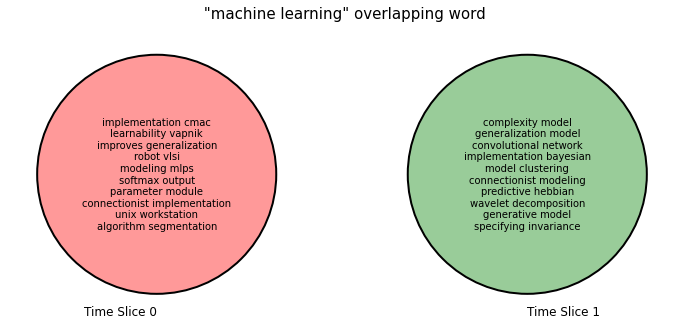

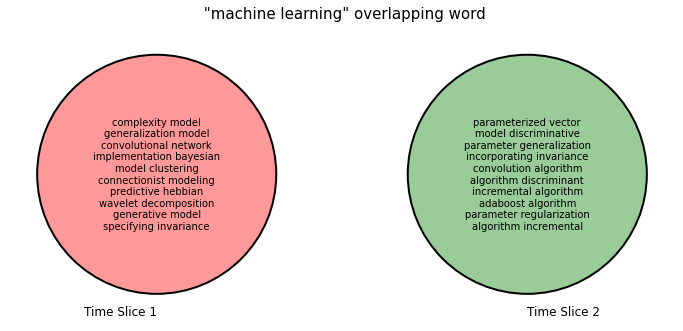

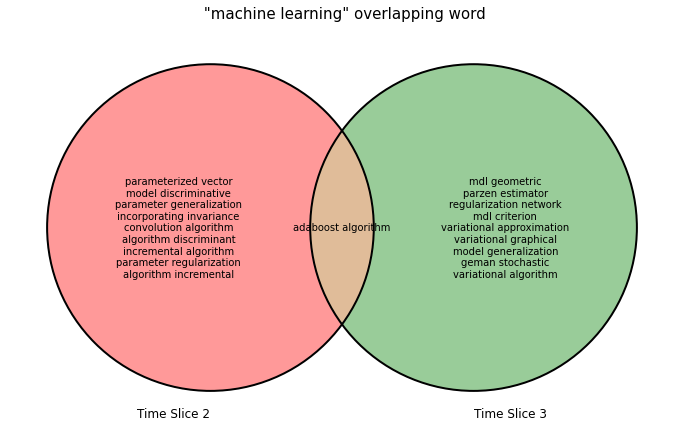

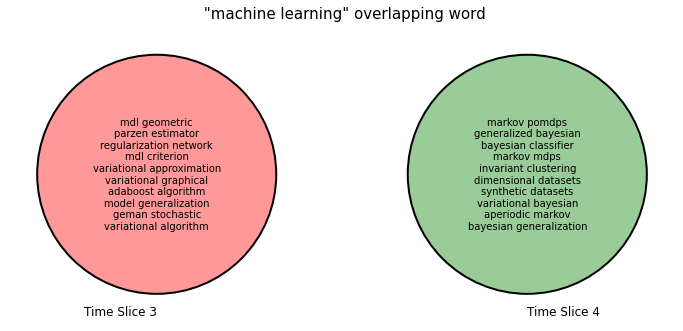

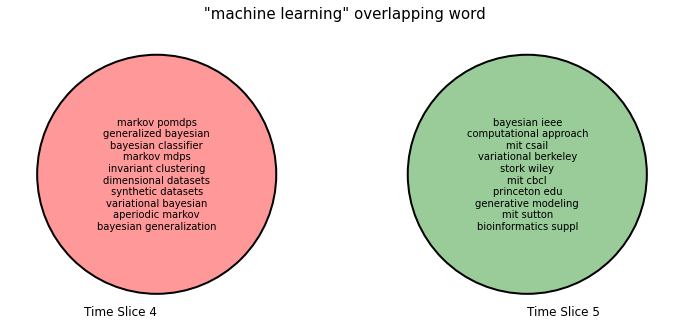

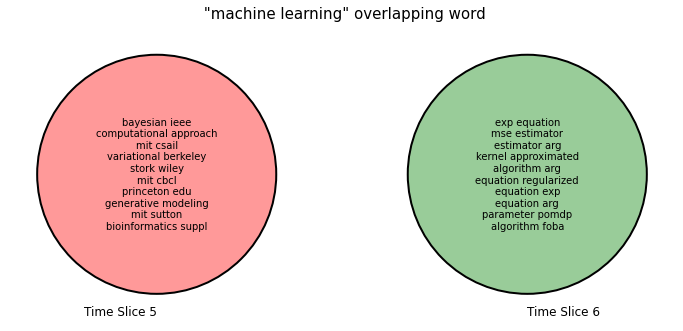

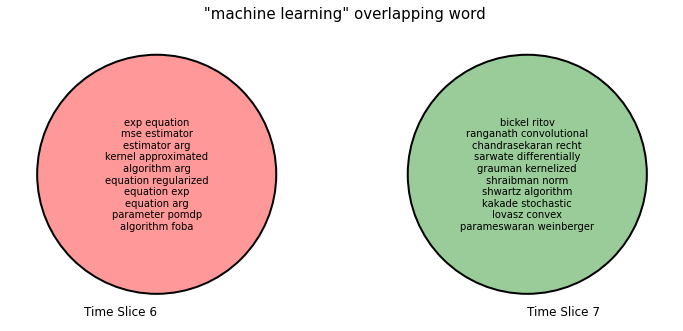

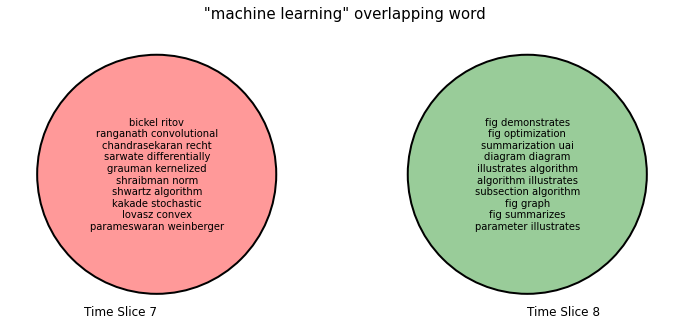

In [77]:
# Plot venn diagrams
# https://stackoverflow.com/questions/19841535/python-matplotlib-venn-diagram

from matplotlib_venn import venn2, venn2_circles
from matplotlib_venn import venn3
from matplotlib import pyplot as plt
from matplotlib_venn_wordcloud import venn2_wordcloud

def monitoring_sets(keyword, all_slice_nns):
     keyword_sets =  [n[keyword] for nn in all_slice_nns for n in nn if keyword in n.keys()]
     return keyword_sets

def venn(keyword, all_slice_nns):
    keyword_sets = monitoring_sets(keyword, all_slice_nns)
    
    for _ , s in enumerate(keyword_sets): 
      # print((keyword_sets[_]))
      # print((keyword_sets[_ + 1]))
      i = _ + 1
      if i < len(keyword_sets):
        fig, ax = plt.subplots(figsize = (12,10))
        ax.set_title(f' "{keyword}" overlapping word', fontsize=15)
        # venn2_wordcloud([keyword_sets[_] , keyword_sets[i] ])
        v = venn2([ keyword_sets[_] , keyword_sets[i]], (f'Time Slice {_}', f'Time Slice {i}'))


        overlap_names = set([name for name in list(keyword_sets[_]) if name in list(keyword_sets[i])])

        v.get_label_by_id('10').set_text('\n'.join(keyword_sets[_] - overlap_names))
        v.get_label_by_id('01').set_text('\n'.join(keyword_sets[i] - overlap_names))
        
        a = keyword_sets[_].intersection(keyword_sets[i])
        if a != 0 and v.get_label_by_id('11') != None: 
          v.get_label_by_id('11').set_text('\n'.join(overlap_names))
        c = venn2_circles( [ keyword_sets[_], keyword_sets[i] ], linestyle='solid')
        plt.show()


v = venn("machine learning", all_slice_nn)


In [ ]:
# import matplotlib.pyplot as plt
# from matplotlib_venn import venn3

# set1 = set(['A', 'B', 'C'])
# set2 = set(['B', 'C', 'F'])

# venn3([set1, set2], ('Group1', 'Group2'))

# plt.show()

In [ ]:
# log_stability(nn_8_[0]["Reinforcement Learning"], nn_7_[0]["Reinforcement Learning"])


In [ ]:
# v = [n for n in nn_2_] 



# list(nn_2_[0].keys())[0]